In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import (fock, coherent, basis, destroy, qeye, tensor, wigner, mesolve, ptrace)

import scipy
from scipy.ndimage import gaussian_filter
import pickle
import seaborn as sns

import skimage as ski
from skimage import measure

import glob
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

## Task A

### Plotting

In [2]:
wigner_files = sorted(glob.glob('../data/synthetic/noisy_wigner_*.pickle'))

NameError: name 'wigner_files' is not defined

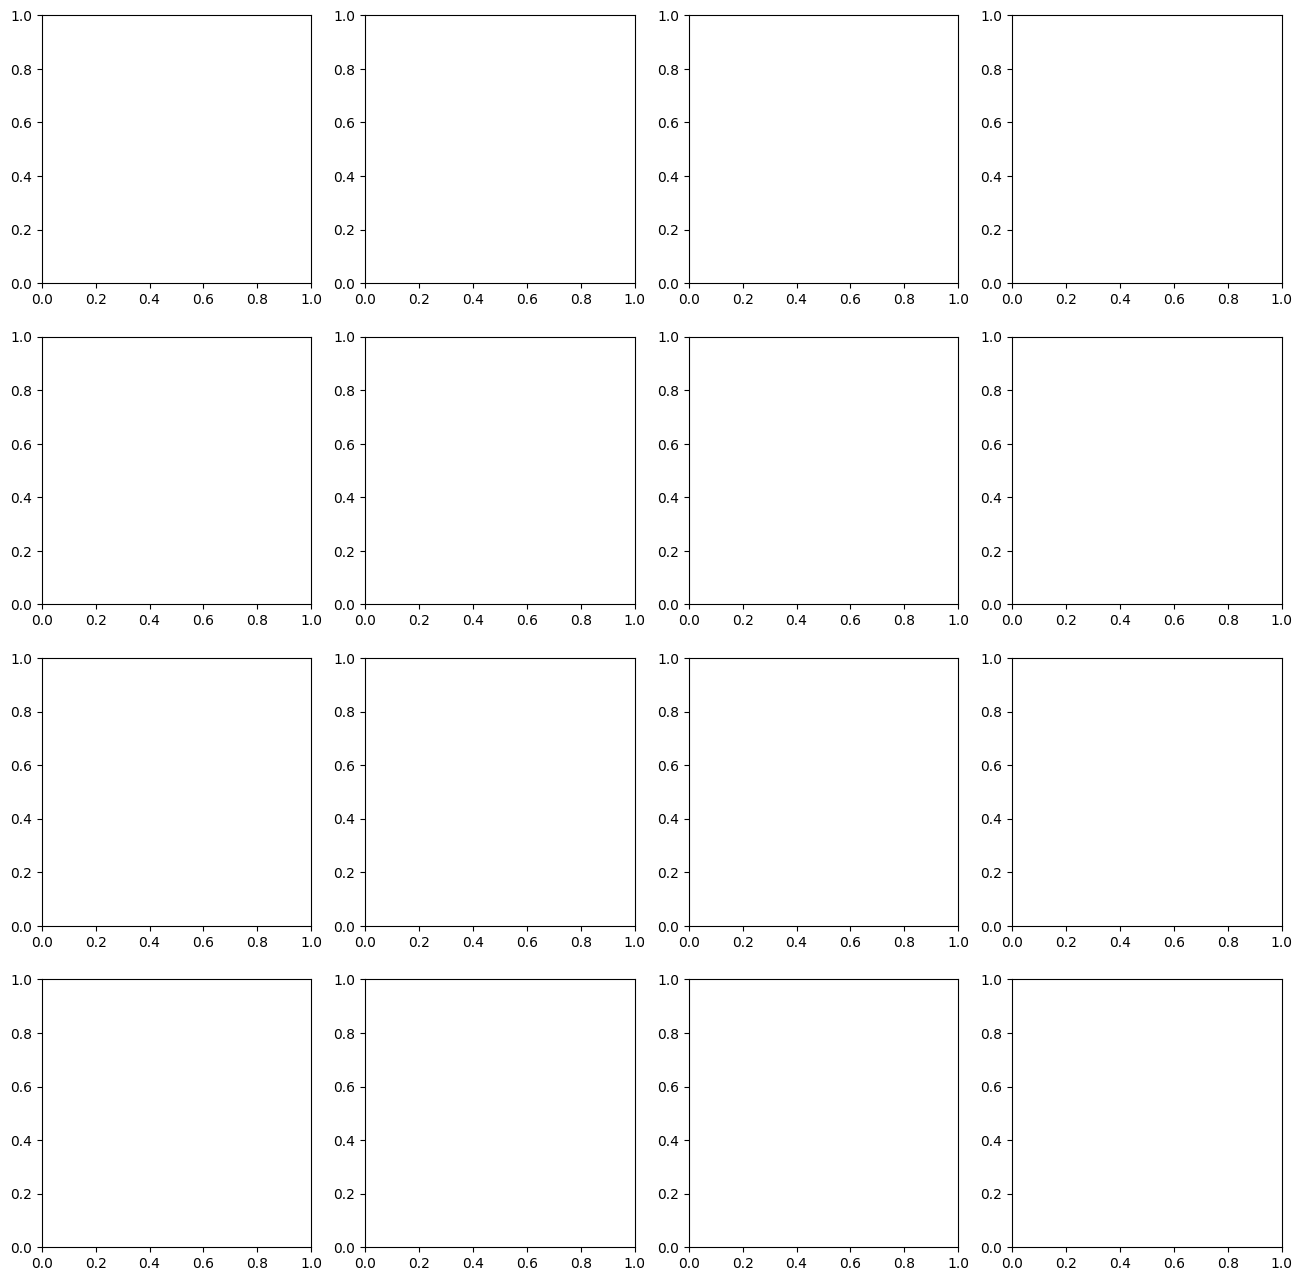

In [19]:
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()
for i, file_path in enumerate(wigner_files):
  if i >= 16: 
    break
    
  data = pickle.load(open(file_path, 'rb'))
  
  x = np.array(data[0])
  y = np.array(data[1])
  wigner_data = np.array(data[2])
  
  base_name = os.path.basename(file_path).replace('.pickle', '')
  np.save(f'../data/synthetic_npy/{base_name}_x.npy', x)
  np.save(f'../data/synthetic_npy/{base_name}_y.npy', y)
  np.save(f'../data/synthetic_npy/{base_name}_wigner.npy', wigner_data)
  
  axes[i].set_title(f'Wigner {i}')
  axes[i].set_xlabel('')
  axes[i].set_ylabel('')
  axes[i].set_xticks([])
  axes[i].set_yticks([])


  # data cleaning
  edge_location = len(wigner_data) -1 
  b = (sum(wigner_data[edge_location, :]) + sum(wigner_data[:, edge_location]) + sum(wigner_data[0, :]) + sum(wigner_data[:, 0]))/(4 * edge_location)
  wigner_data = wigner_data - b

  wigner_data[np.isnan(wigner_data)] = 0

  wigner_integral = np.trapz(np.trapezoid(wigner_data, x), y)
  wigner_data = wigner_data/ wigner_integral

  wigner_data[np.isnan(wigner_data)] = 0

  sigma = 3
  wigner_data = gaussian_filter(wigner_data, sigma=sigma)
  sns.heatmap(abs(wigner_data), cmap='coolwarm', cbar=True, ax=axes[i])

  # sns.heatmap(wigner_data, cmap='coolwarm', cbar=False, ax=axes[i])

plt.tight_layout()
plt.show()

### Denoising

In [3]:
data = pickle.load(open(wigner_files[0], 'rb'))
x = np.array(data[0])
y = np.array(data[1])
wigner_data = np.array(data[2])

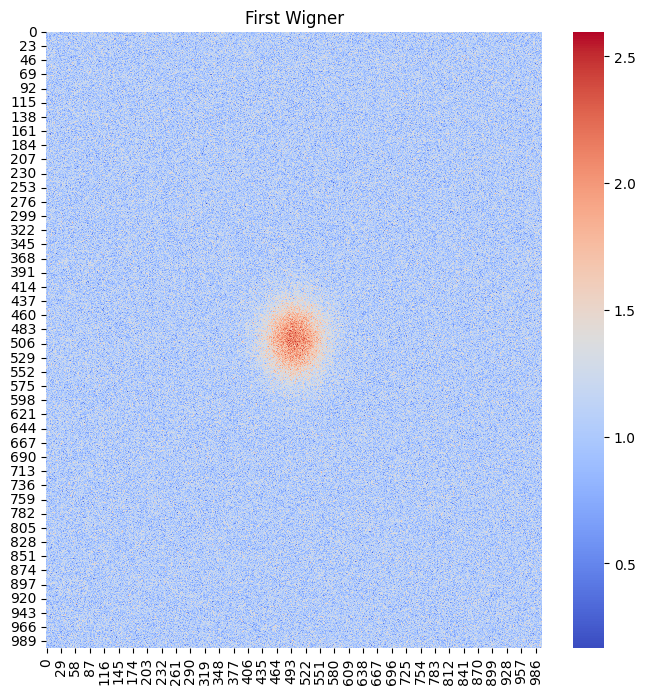

/tmp/ipykernel_3708096/215812373.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  wigner_integral = np.trapz(np.trapz(wigner_data, x), y)


Wigner integral: 1.6922508600129715


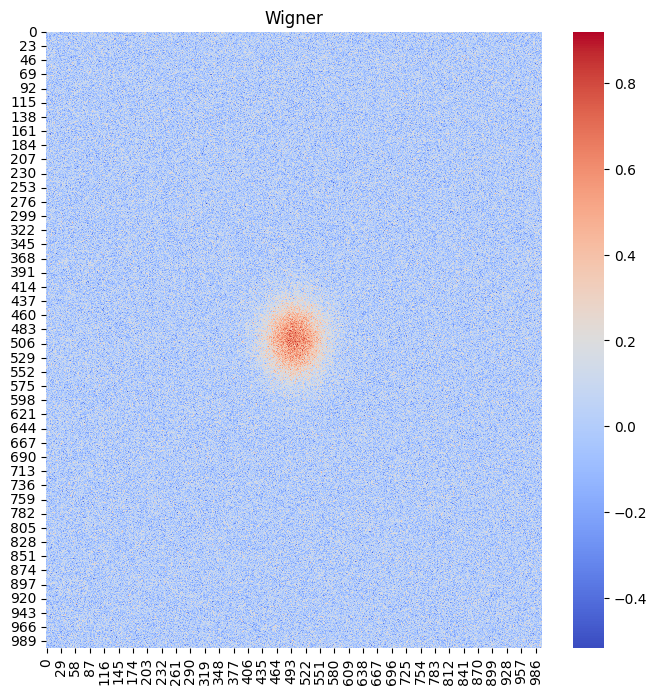

In [39]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(wigner_data, cmap='coolwarm', cbar=True, ax=ax)
ax.set_title('First Wigner')
plt.show()

# In most physical states, at the edges of phase space $W(x,p) \rightarrow0$.  This should allow you to estimate the value of $b$.
edge_location = len(wigner_data) -1 
b = (sum(wigner_data[edge_location, :]) + sum(wigner_data[:, edge_location]) + sum(wigner_data[0, :]) + sum(wigner_data[:, 0]))/(4 * edge_location)
wigner_data = wigner_data - b

# Normalize the Wigner function
wigner_integral = np.trapz(np.trapz(wigner_data, x), y)
wigner_data = wigner_data/ wigner_integral
print(f'Wigner integral: {wigner_integral}')


fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(wigner_data, cmap='coolwarm', cbar=True, ax=ax)
ax.set_title('Wigner')
plt.show()

Wigner integral after filtering: 0.9995014451677082


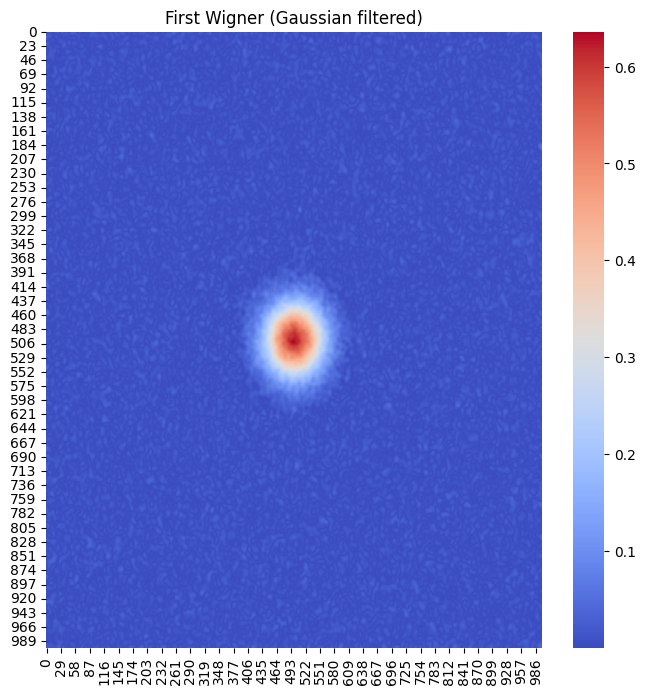

In [40]:
sigma = 3
wigner_data = gaussian_filter(wigner_data, sigma=sigma)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(abs(wigner_data), cmap='coolwarm', cbar=True, ax=ax)
ax.set_title('First Wigner (Gaussian filtered)')

wigner_integral_after = np.trapezoid(np.trapezoid(wigner_data, x), y)
print(f'Wigner integral after filtering: {wigner_integral_after}')

plt.show()

Number of contours found: 4


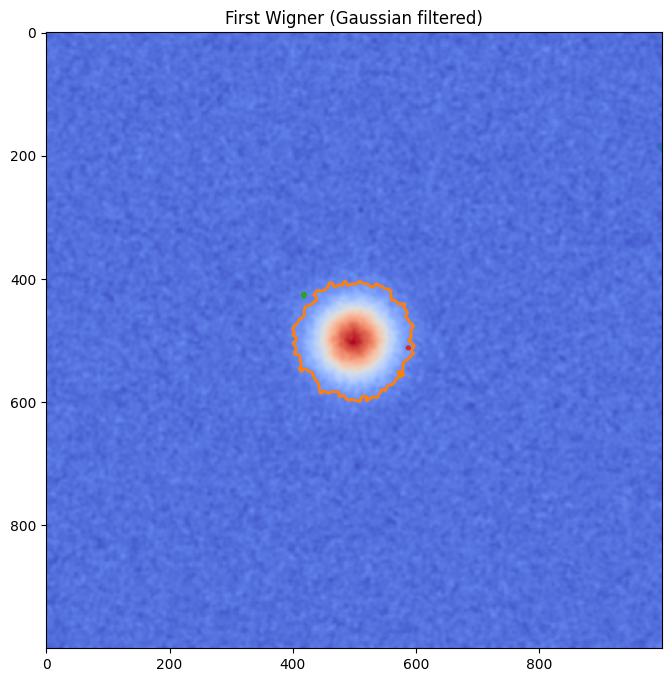

In [ ]:
# use contour finding from skimage to find the contours of the Wigner function
contours = measure.find_contours(abs(wigner_data), 0.05)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(wigner_data, cmap='coolwarm', interpolation='nearest')
perimeters = list(map(lambda x: np.sqrt(np.diff(x, axis=0)**2).sum(), contours))
contour_mask = list(map(lambda x: x > 10, perimeters))
contours = [contour for contour, mask in zip(contours, contour_mask) if mask]
for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax.set_title('First Wigner (Gaussian filtered)')
print(f'Number of contours found: {len(contours)}')
plt.show()


## Task B

In [2]:
def gen_wigners(N, N_points=1000) -> list:
    """
    Generates N Wigner functions for coherent states with random amplitudes.
    """
    wigner_functions = []
    xvec = np.linspace(-5,5,1000)
    for i in range(N):
        alpha = np.random.rand() + 1j * np.random.rand()
        psi = (coherent(15, alpha) - coherent(15, -alpha)).unit()
        W_n = wigner(psi, xvec, xvec)
        wigner_functions.append(W_n)
    return wigner_functions

In [4]:
# write the noise models alice and ryan you bitches
def gauss(image):
  mean=0
  var=0.02
  (row, col) = np.shape(image)
  sigma = var**0.5
  gauss = np.random.normal(mean,sigma,size=(row,col))
  noisy = image + gauss
  return noisy

def sandp(image):
  s_vs_p=0.5
  amount=0.05
  (row, col) = np.shape(image)
  out = np.copy(image)

  # Number of salt pixels
  num_salt = int(np.ceil(amount * image.size * s_vs_p))
  row_coords = np.random.randint(0, row, num_salt)
  col_coords = np.random.randint(0, col, num_salt)
  out[row_coords, col_coords] = 1

  # Number of pepper pixels
  num_pepper = int(np.ceil(amount * image.size * (1.0 - s_vs_p)))
  row_coords_p = np.random.randint(0, row, num_pepper)
  col_coords_p = np.random.randint(0, col, num_pepper)
  out[row_coords_p, col_coords_p] = 0
  return out

def poisson(image):
  # Ensure we have no negative values
  clipped = np.clip(image, 0, None)
  # Count distinct values
  vals = len(np.unique(clipped))
  # Guard if everything is zero
  if vals < 2:
      return clipped
  # Use next power of two
  vals = 2 ** np.ceil(np.log2(vals))
  # Poisson sampling
  noisy = np.random.poisson(clipped * vals) / float(vals)
  return noisy

def speckle(image):
  (row, col) = np.shape(image)
  gauss = np.random.randn(row,col)     
  noisy = image + image * gauss
  return noisy

def convo(image):
  # Applies a 2D box filter (mean filter)
  kernel_size = 69
  noisy = scipy.ndimage.uniform_filter(image, size=kernel_size, mode='constant')
  return noisy

noise_functions = [gauss, sandp, poisson, speckle, convo]

In [5]:
class WignerDataset(Dataset):
    def __init__(self, noise_functions, num_samples=100, N_points=1000):
        """
        Args:
            noise_functions (list): List of noise function callables.
            num_samples (int): Number of Wigner functions to generate.
            N_points (int): Points along one axis for generated 2D functions.
        """
        self.noise_functions = noise_functions
        self.num_samples = num_samples
        self.N_points = N_points

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        xvec = np.linspace(-5, 5, self.N_points)
        alpha = np.random.rand() + 1j * np.random.rand()
        psi = (coherent(15, alpha) - coherent(15, -alpha)).unit()
        clean = wigner(psi, xvec, xvec)

        noise_fn = np.random.choice(self.noise_functions)
        noisy = noise_fn(clean)

        clean_tensor = torch.from_numpy(clean).float().unsqueeze(0)
        noisy_tensor = torch.from_numpy(noisy).float().unsqueeze(0)
        return noisy_tensor, clean_tensor

dataset = WignerDataset(noise_functions=noise_functions)

In [6]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()

        # Encoder: simple two-layer conv blocks
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Decoder: simple two-layer conv blocks
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.dec2 = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=3, padding=1)
        )
        # Down- and up-sampling layers
        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
    def forward(self, x):
        # Encoder path
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))

        # Decoder path
        d1 = self.up(e2)
        d2 = self.dec1(d1)
        out = self.dec2(d2)
        return out


In [7]:
model = SimpleUNet()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [8]:
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model, device_ids=[0, 1])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train_model(model, dataloader, optimizer, criterion, epochs=5, device='cpu'):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (noisy, clean) in enumerate(dataloader):
            # Handle NaN values in the input
            noisy = torch.nan_to_num(noisy, nan=0.0)
            clean = torch.nan_to_num(clean, nan=0.0)
            
            # Transfer data to the appropriate device
            noisy = noisy.to(device)
            clean = clean.to(device)
            
            # Forward pass
            optimizer.zero_grad()    # Clear previous gradients
            outputs = model(noisy)
            loss = criterion(outputs, clean)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Update running loss
            running_loss += loss.item()
            
            # Print progress every 10 batches
            if (i + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}")
        
        avg_loss = running_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}] completed, Average Loss: {avg_loss:.4f}")
    
    print("Training finished!")

Using 2 GPUs


In [14]:
dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=8,
    shuffle=True, 
    num_workers=16,
    pin_memory=True
)

# Run training on the model
train_model(model, dataloader, optimizer, criterion, epochs=10, device=device)

# Save the model
torch.save(model.state_dict(), 'model.pth')

Epoch [1/10], Batch [10/13], Loss: 0.0013
Epoch [1/10] completed, Average Loss: 0.0022
Epoch [2/10], Batch [10/13], Loss: 0.0006
Epoch [2/10] completed, Average Loss: 0.0006
Epoch [3/10], Batch [10/13], Loss: 0.0004
Epoch [3/10] completed, Average Loss: 0.0004
Epoch [4/10], Batch [10/13], Loss: 0.0003
Epoch [4/10] completed, Average Loss: 0.0002
Epoch [5/10], Batch [10/13], Loss: 0.0002
Epoch [5/10] completed, Average Loss: 0.0002
Epoch [6/10], Batch [10/13], Loss: 0.0002
Epoch [6/10] completed, Average Loss: 0.0002
Epoch [7/10], Batch [10/13], Loss: 0.0001
Epoch [7/10] completed, Average Loss: 0.0001
Epoch [8/10], Batch [10/13], Loss: 0.0002
Epoch [8/10] completed, Average Loss: 0.0001
Epoch [9/10], Batch [10/13], Loss: 0.0001
Epoch [9/10] completed, Average Loss: 0.0001
Epoch [10/10], Batch [10/13], Loss: 0.0001
Epoch [10/10] completed, Average Loss: 0.0002
Training finished!


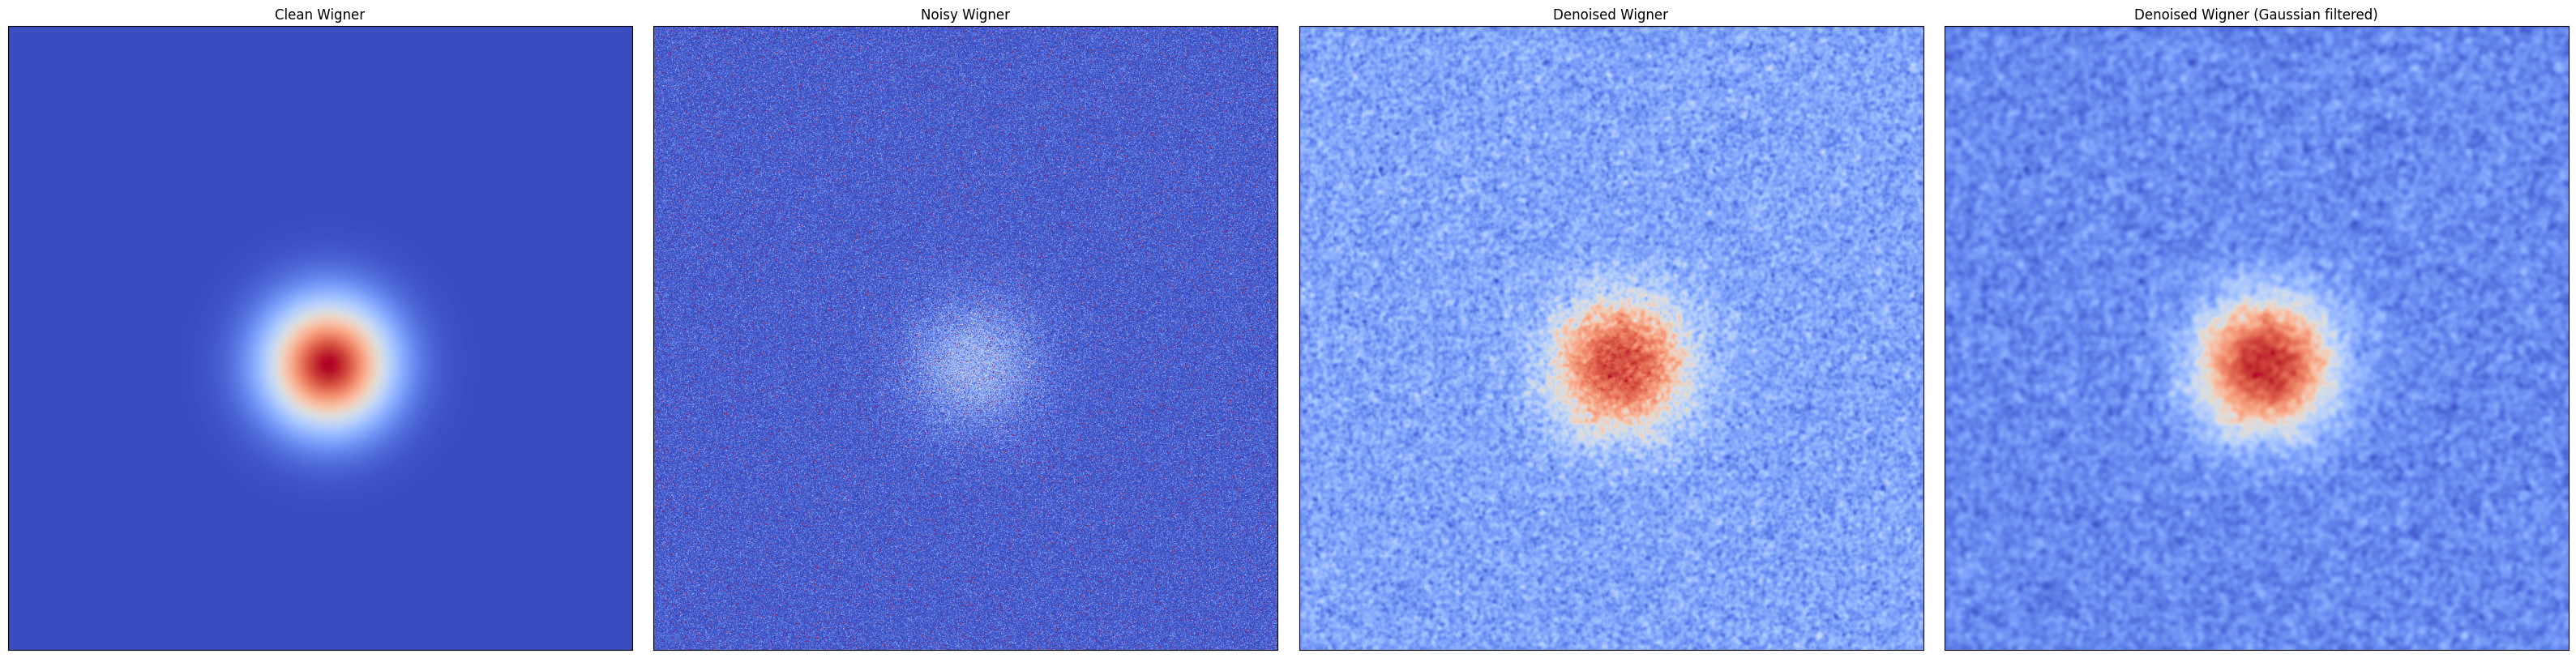

In [22]:
state_dict = torch.load("model.pth")

# If 'module.' prefix is there, strip it
from collections import OrderedDict
new_state_dict = OrderedDict()

for k, v in state_dict.items():
    new_key = k.replace("module.", "")  # remove 'module.' prefix
    new_state_dict[new_key] = v

# Create model and load updated state dict
model = SimpleUNet()
model.load_state_dict(new_state_dict)

model.eval()
model.to(device)

# Generate a new Wigner function for testing
xvec = np.linspace(-5, 5, 1000)
alpha = np.random.rand() + 1j * np.random.rand()

# make a cat state for psi
psi = coherent(15, alpha)

clean = wigner(psi, xvec, xvec)
# Add noise
noisy = poisson(sandp(gauss(convo(clean))))

# noisy = np.load('../data/synthetic_npy/noisy_wigner_2_wigner.npy')

# Convert to torch tensors
clean_tensor = torch.from_numpy(clean).float().unsqueeze(0).to(device)
noisy_tensor = torch.from_numpy(noisy).float().unsqueeze(0).to(device)

# Add batch dimension
clean_tensor = clean_tensor.unsqueeze(0)
noisy_tensor = noisy_tensor.unsqueeze(0)

# Pass through the model
with torch.no_grad():
    denoised_tensor = model(noisy_tensor)
    
# Convert back to numpy
denoised = denoised_tensor.cpu().numpy().squeeze()

# Apply Gaussian filter to denoised result
sigma = 3
denoised_filtered = gaussian_filter(denoised, sigma=sigma)

# Plot the results
fig, axes = plt.subplots(1, 4, figsize=(32, 8))
axes[0].imshow(clean, cmap='coolwarm')
axes[0].set_title('Clean Wigner')
axes[1].imshow(noisy, cmap='coolwarm')
axes[1].set_title('Noisy Wigner')
axes[2].imshow(denoised, cmap='coolwarm')
axes[2].set_title('Denoised Wigner')
axes[3].imshow(denoised_filtered, cmap='coolwarm')
axes[3].set_title('Denoised Wigner (Gaussian filtered)')

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
dm_ref = (coherent * coherent.dag()).full()

# convert noisy tensor and denoised tensor to numpy arrays
noisy = noisy_tensor.cpu().numpy().squeeze()
denoised = denoised_tensor.cpu().numpy().squeeze()

# rewrite the 
a = wigner()


sample_measurement_operators(X, Y, Z, N, num_samples=100)

reconstruct_density_matrix(w_exp_measurements, measurement_operators, N, solver='SCS')

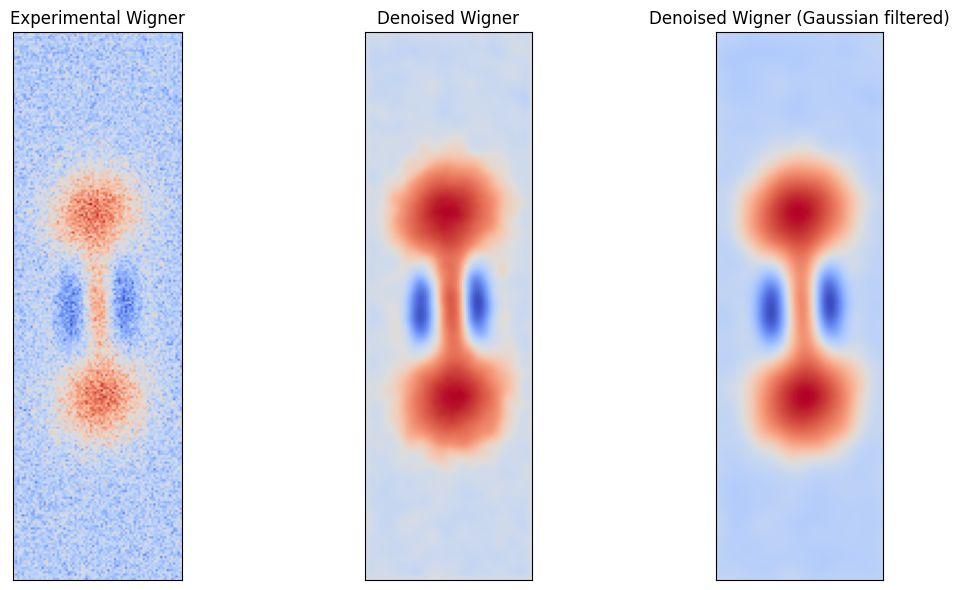

In [21]:
# Generate a new Wigner function for testing
xvec = np.linspace(-5, 5, 1000)
alpha = np.random.rand() + 1j * np.random.rand()

# load the pickle
data = pickle.load(open('../data/experimental/wigner_cat_plus_25.pickle', 'rb'))
experiment = data[2]

noisy_tensor = torch.from_numpy(experiment).float().unsqueeze(0).to(device)

noisy_tensor = noisy_tensor.unsqueeze(0)

# Pass through the model
with torch.no_grad():
    denoised_tensor = model(noisy_tensor)
    
# Convert back to numpy
denoised = denoised_tensor.cpu().numpy().squeeze()

# Apply Gaussian filter to denoised result
sigma = 3
denoised_filtered = gaussian_filter(denoised, sigma=sigma)

# Plot the results
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
axes[0].imshow(experiment, cmap='coolwarm')
axes[0].set_title('Experimental Wigner')
axes[1].imshow(denoised, cmap='coolwarm')
axes[1].set_title('Denoised Wigner')
axes[2].imshow(denoised_filtered, cmap='coolwarm')
axes[2].set_title('Denoised Wigner (Gaussian filtered)')

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


# Stuff from 1b

In [23]:
from scipy.linalg import expm
import cvxpy as cp

def annihilation_operator(N):
  a = np.zeros((N, N), dtype=complex)
  for n in range(1, N):
    a[n-1, n] = np.sqrt(n)
  return a

def displacement_operator(alpha, N):
  a = annihilation_operator(N)
  a_dag = a.conj().T
  D_gen = alpha * a_dag - np.conj(alpha) * a
  return expm(D_gen)

def parity_operator(N):
    a = annihilation_operator(N)
    a_dag = a.conj().T
    number_operator = a_dag @ a
    return expm(1j * np.pi * number_operator)


def parity_operator_fock(N):
    return np.diag([(-1)**n for n in range(N)])


def wigner(alpha, rho, N):
    D = displacement_operator(alpha, N)
    P = parity_operator(N)
    D_dag = D.conj().T
    return (2 / np.pi) * np.real(np.trace(D @ P @ D_dag @ rho))


def get_measure_op(alpha, N):
  D = displacement_operator(alpha, N)
  P = parity_operator(N)
  D_dag = D.conj().T
  I = np.eye(N)
  return 0.5 * (I + D @ P @ D_dag)


def fidelity(rho_reconstructed, rho_true):
  root_rho_true = np.sqrtm(rho_true)
  inner = root_rho_true @ rho_reconstructed @ root_rho_true
  sqrt_inner = np.sqrtm(inner)
  fid = np.real(np.trace(sqrt_inner))
  return fid ** 2

In [16]:
def get_filtered_contours(Z, contour_level=0.4, min_length=20):
    contours = measure.find_contours(np.abs(Z), level=contour_level)
    print('-----------')
    print(len(contours))
    print('----------')
    def contour_length(contour):
        d = np.diff(contour, axis=0)
        return np.sum(np.sqrt(np.sum(d**2, axis=1)))
    filtered_contours = [cnt for cnt in contours if contour_length(cnt) > min_length]
    return filtered_contours

def convert_contour_to_physical(contour, X, Y):
    physical_x = np.interp(contour[:, 1], np.arange(len(X)), X)
    physical_y = np.interp(contour[:, 0], np.arange(len(Y)), Y)
    return np.column_stack((physical_x, physical_y))

def sample_contours_and_background(X, Y, Z, contour_level=0.4, min_length=2, total_points=250, inside_ratio=0.4):
    wigner_data = np.nan_to_num(Z.copy())

    print(wigner_data.shape)
    print(X.shape)
    print(Y.shape)

    # For rectangular grids, we need to handle different dimensions for rows and columns
    rows, cols = wigner_data.shape
    edge_row = rows - 1
    edge_col = cols - 1
    
    # Calculate average of the four edges (top, bottom, left, right)
    top_edge_avg = np.sum(wigner_data[0, :]) / cols
    bottom_edge_avg = np.sum(wigner_data[edge_row, :]) / cols
    left_edge_avg = np.sum(wigner_data[:, 0]) / rows
    right_edge_avg = np.sum(wigner_data[:, edge_col]) / rows
    
    # Take the average of all four edges
    b = (top_edge_avg + bottom_edge_avg + left_edge_avg + right_edge_avg) / 4
    wigner_data = wigner_data - b

    # Normalize the Wigner function
    # Get grid step sizes for proper integration
    dx = np.mean(np.diff(X))
    dy = np.mean(np.diff(Y))
    
    # For rectangular grids, directly compute the integral with proper scaling
    wigner_integral = np.sum(wigner_data) * dx * dy
    wigner_data = wigner_data/ wigner_integral
    sigma = 3
    wigner_data = gaussian_filter(wigner_data, sigma=sigma)

    filtered_contours = get_filtered_contours(wigner_data, contour_level, min_length)

    fig, ax = plt.subplots(figsize=(8, 6))
    extent = [X.min(), X.max(), Y.min(), Y.max()]
    im = ax.imshow(Z, extent=extent, origin='lower', aspect='auto')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Original Wigner Function with Contours')

    for contour in filtered_contours:
        try:
            # Convert contour coordinates to indices and ensure they are within bounds
            x_indices = contour[:, 1].astype(int)
            y_indices = contour[:, 0].astype(int)
            
            # Filter out invalid indices
            valid_mask = (x_indices >= 0) & (x_indices < len(X)) & (y_indices >= 0) & (y_indices < len(Y))
            
            if np.any(valid_mask):
                ax.plot(X[x_indices[valid_mask]], Y[y_indices[valid_mask]], color='white')
        except Exception as e:
            print(f"Error plotting contour: {e}")
    fig.colorbar(im, label='Wigner Function')
    plt.show()


    roi_polygons = [convert_contour_to_physical(contour, X, Y) for contour in filtered_contours]
    XX, YY = np.meshgrid(X, Y, indexing='ij')
    grid_points = np.column_stack((XX.ravel(), YY.ravel()))
    I, J = np.indices((len(X), len(Y)))
    grid_indices = np.column_stack((I.ravel(), J.ravel()))
    inside_mask = np.zeros(len(grid_points), dtype=bool)
    for polygon in roi_polygons:
        poly_path = Path(polygon)
        inside_mask |= poly_path.contains_points(grid_points)
    inside_points = grid_points[inside_mask]
    outside_points = grid_points[~inside_mask]
    inside_idx = grid_indices[inside_mask]
    outside_idx = grid_indices[~inside_mask]
    desired_inside = int(total_points * inside_ratio)
    desired_outside = total_points - desired_inside
    if len(inside_points) < desired_inside:
        sampled_inside_points = inside_points
        sampled_inside_idx = inside_idx
        extra_needed = total_points - len(inside_points)
        if len(outside_points) < extra_needed:
            sampled_outside_points = outside_points
            sampled_outside_idx = outside_idx
        else:
            samp_idx = np.random.choice(len(outside_points), size=extra_needed, replace=False)
            sampled_outside_points = outside_points[samp_idx]
            sampled_outside_idx = outside_idx[samp_idx]
    elif len(outside_points) < desired_outside:
        sampled_outside_points = outside_points
        sampled_outside_idx = outside_idx
        extra_needed = total_points - len(outside_points)
        if len(inside_points) < extra_needed:
            sampled_inside_points = inside_points
            sampled_inside_idx = inside_idx
        else:
            samp_idx = np.random.choice(len(inside_points), size=extra_needed, replace=False)
            sampled_inside_points = inside_points[samp_idx]
            sampled_inside_idx = inside_idx[samp_idx]
    else:
        samp_inside = np.random.choice(len(inside_points), size=desired_inside, replace=False)
        samp_outside = np.random.choice(len(outside_points), size=desired_outside, replace=False)
        sampled_inside_points = inside_points[samp_inside]
        sampled_inside_idx = inside_idx[samp_inside]
        sampled_outside_points = outside_points[samp_outside]
        sampled_outside_idx = outside_idx[samp_outside]
    sampled_points = np.concatenate([sampled_inside_points, sampled_outside_points], axis=0)
    sampled_indices = np.concatenate([sampled_inside_idx, sampled_outside_idx], axis=0)
    sampled_X = sampled_points[:, 0]
    sampled_Y = sampled_points[:, 1]
    sampled_Z = np.array([Z[i, j] for i, j in sampled_indices])
    return sampled_X, sampled_Y, sampled_Z

In [17]:
def sample_measurement_operators(X, Y, Z, N, num_samples=100):
    sampled_X, sampled_Y, sampled_Z = sample_contours_and_background(X, Y, Z)

    alpha_samples = []
    w_exp_measurements = []
    measurement_operators = []

    for x, y, w_val in zip(sampled_X, sampled_Y, sampled_Z):
        alpha = x + 1j*y
        # convert Wigner to expectation value via your calibration
        w_k = 0.5 * (1 + (np.pi/2) * w_val)

        alpha_samples.append(alpha)
        w_exp_measurements.append(w_k)
        measurement_operators.append(get_measure_op(alpha, N))

    return alpha_samples, w_exp_measurements, measurement_operators

In [18]:
def reconstruct_density_matrix(w_exp_measurements, measurement_operators, N, solver='SCS'):
    rho = cp.Variable((N, N), complex=True)

    constraints = [
        rho == rho.H,                   # Hermitian constraint
        rho >> np.zeros((N, N)),         # Positive semidefinite constraint
        cp.trace(rho) == 1              # Trace equals 1
    ]

    # Build the objective function (least squares formulation)
    objective_terms = []
    for i in range(len(measurement_operators)):
        E_k_numpy = measurement_operators[i]  # measurement operator as a numpy array
        w_k = w_exp_measurements[i]             # experimental measurement value

        # The term is the squared difference of the predicted measurement value
        # (given by trace(E_k @ rho)) and the experimental outcome.
        term = cp.square(cp.abs(cp.trace(E_k_numpy @ rho) - w_k))
        objective_terms.append(term)

    # Formulate the overall optimization objective by summing the individual terms.
    objective = cp.Minimize(cp.sum(objective_terms))

    # Define and solve the optimization problem.
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=solver)

    return rho.value, prob